In [137]:
!pip install -q geopandas
!pip install -q lxml
!pip install -q bs4
!pip install -q rapidfuzz
!pip install -q geopandas matplotlib contextily

In [138]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import networkx as nx
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px

In [127]:
neighborhoods = gpd.read_file("NYCneighbourhoods.geojson")
apartments    = pd.read_csv('listings.csv', low_memory=False)
complaints    = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_ (1).csv')
population    = pd.read_excel("nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx", 
                              sheet_name="2010, 2020, and Change", 
                              skiprows= [0,1,2])

housing_prices_bronx         = pd.read_excel("rollingsales_bronx.xlsx",        skiprows= [0,1,2,3])
housing_prices_brooklyn      = pd.read_excel("rollingsales_brooklyn.xlsx",     skiprows= [0,1,2,3])
housing_prices_manhattan     = pd.read_excel("rollingsales_manhattan.xlsx",    skiprows= [0,1,2,3])
housing_prices_queens        = pd.read_excel("rollingsales_queens.xlsx",       skiprows= [0,1,2,3])
housing_prices_staten_island = pd.read_excel("rollingsales_statenisland.xlsx", skiprows= [0,1,2,3])

housing_prices = pd.concat([housing_prices_bronx,
                            housing_prices_brooklyn, 
                            housing_prices_manhattan, 
                            housing_prices_queens, 
                            housing_prices_staten_island])

In [128]:
#PREPROCESSING population
population = population[population["GeoType"] == "NTA2020"][["Name", "Pop_20"]]

In [129]:
#PREPROCESSING housing_prices
housing_prices = housing_prices[housing_prices['SALE PRICE'] >= 100000]
housing_prices = housing_prices[housing_prices['TOTAL UNITS'] != 0]
housing_prices['AVERAGE PRICE'] = housing_prices['SALE PRICE'] / housing_prices['TOTAL UNITS']

housing_prices= housing_prices[['AVERAGE PRICE', 'NEIGHBORHOOD']]

In [130]:
#PREPROCESSING apartments
apartments['price'] = apartments['price'].replace({'\$':'', ',':''}, regex = True).astype(float)
apartments.dropna(subset=['reviews_per_month'], inplace=True)
apartments = apartments[apartments['reviews_per_month'] <= 31]
apartments = apartments[apartments['price'] <= 20000]
apartments = apartments[apartments['room_type']=='Entire home/apt']

guest_review_rate = 0.5
# avg_stay_duration = 4.5

apartments['days_booked_per_month'] = apartments['number_of_reviews_ltm'] / 12.0 * apartments['minimum_nights']
apartments = apartments[apartments['days_booked_per_month'] <= 30]
apartments['avg_monthly_revenue'] = (apartments['days_booked_per_month'] * apartments['price']) / guest_review_rate

apartments = apartments[['id', 'latitude', 'longitude', 'avg_monthly_revenue']]

In [131]:
geometry_ap = [Point(xy) for xy in zip(apartments['longitude'], apartments['latitude'])]
geometry_co = [Point(xy) for xy in zip(complaints['Longitude'], complaints['Latitude'])]

# Create a GeoDataFrame from the apartments DataFrame
apartments_gdf = gpd.GeoDataFrame(apartments, geometry=geometry_ap)
complaints_gdf = gpd.GeoDataFrame(complaints, geometry=geometry_co)

apartments_gdf.crs = "EPSG:4326"
complaints_gdf.crs = "EPSG:4326"

joined_ap = gpd.sjoin(apartments_gdf, neighborhoods, how="left", predicate="within")
joined_co = gpd.sjoin(complaints_gdf, neighborhoods, how="left", predicate="within")

In [132]:
ap_neighborhood_names = joined_ap["NTAName"]
co_neighborhood_names = joined_co["NTAName"]

apartments_with_neighborhoods = pd.concat([apartments, ap_neighborhood_names], axis=1)
complaints_with_neighborhoods = pd.concat([complaints, co_neighborhood_names], axis=1)

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

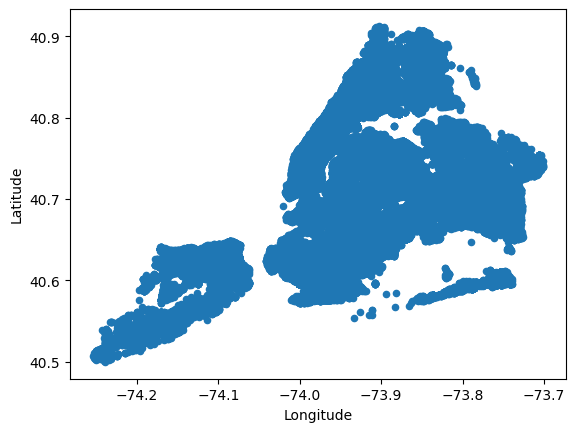

In [133]:
#Check NAN values
complaints_with_neighborhoods.isnull().sum()

complaints_with_neighborhoods["OFNS_DESC"].unique()
df_comp = complaints_with_neighborhoods[complaints_with_neighborhoods["OFNS_DESC"]!="OFFENSES INVOLVING FRAUD"]

df_comp = df_comp[df_comp['NTAName'].notna()]

interesting_columns = ["CMPLNT_NUM", "OFNS_DESC", "NTAName", "Latitude", "Longitude"]
df_comp = df_comp[interesting_columns]

df_comp.plot.scatter(y="Latitude", x="Longitude")

In [134]:
complaints_clean = df_comp
airbnb_clean = apartments_with_neighborhoods

In [135]:
population.rename(columns = {"Name": "NTA Name"})
population.rename(columns = {"Pop_20": "population"})
population.columns

Index(['Name', 'Pop_20'], dtype='object')

In [136]:
from rapidfuzz import process


# # Create a function to find the best match for a neighborhood name
def find_best_match(name, choices):
    best_match = process.extractOne(name, choices)
    if best_match is None:
        return None
    return best_match[0] if best_match[1] >= 70 else None

correct_names = airbnb_clean["NTAName"].unique()
other_names = population["NTA Name"].unique()

transformed_names = {name: find_best_match(name, correct_names) for name in other_names}
population['NTA Name'] = population['NTA Name'].map(transformed_names)

KeyError: 'NTA Name'

In [ ]:
housing_price_names = housing_prices["NEIGHBORHOOD"].unique()
print(housing_price_names)
transformed_housing_names = {name: find_best_match(name.lower(), correct_names) for name in housing_price_names}
housing_prices["NTA Name"] = housing_prices["NEIGHBORHOOD"].map(transformed_housing_names)
print(housing_prices["NTA Name"])

In [ ]:
hou_nta = housing_prices["NTA Name"].unique()

In [ ]:
pop_nta = population["NTA Name"].unique()

In [ ]:
ap_NTA = airbnb_clean["NTAName"].unique()

In [ ]:
print(len(hou_nta), len(ap_NTA), len(set(hou_nta).intersection(set(ap_NTA))))

In [ ]:
# complaints_clean = pd.read_excel("complaint_NB.xlsx")
# airbnb_clean = pd.read_excel("AirBNB_NB.xlsx")

In [ ]:
airbnb_clean["NTAName"].unique()
complaints_clean["NTAName"].unique()

#print(len(airbnb_clean["NTAName"].unique()))
#print(len(complaints_clean["NTAName"].unique()))

set1 = set(airbnb_clean["NTAName"].unique())
set2 = set(complaints_clean["NTAName"].unique())
set3 = set(population["NTA Name"].unique())
set4 = set(housing_prices["NTA Name"].unique())

all_NTA = set1.intersection(set2, set3, set4)

print(len(set1))
print(len(set2))
print(len(set3))
print(len(set4))
print(len(all_NTA))

print(len(set1.intersection(set4)))

housing_prices = housing_prices.dropna()

In [ ]:
graph = nx.Graph()

for neighborhood in all_NTA:
    graph.add_node(neighborhood)
    graph.nodes[neighborhood]["population"] = population.loc[population['NTA Name'] == neighborhood, 'Population'].values[0]

for index, complaint_row in complaints_clean.iterrows():
    indexing = "complaint"+str(index)
    graph.add_node(indexing)
    graph.add_edge(indexing, complaint_row["NTAName"], label="complaint_is_in")
    
for index, airbnb_listing in airbnb_clean.iterrows():
    indexing = "listing"+str(index)
    graph.add_node(indexing)
    graph.add_edge(indexing, airbnb_listing["NTAName"], label="airbnb_is_in")
    
    graph.nodes[indexing]["avg_monthly_revenue"] = airbnb_listing["avg_monthly_revenue"]

    
for index, sale in housing_prices.iterrows():
    indexing = "sale"+str(index)
    graph.add_node(indexing)
    graph.add_edge(indexing, sale["NTA Name"], label="sale_is_in")
    
    graph.nodes[indexing]["price"] = sale["AVERAGE PRICE"]

    

In [ ]:
for neighborhood in all_NTA:
#     c   = graph.nodes[neighborhood]["amount_of_complaints"]
    pop = graph.nodes[neighborhood]["population"]
#     a   = graph.nodes[neighborhood]["amount_of_airbnbs"]
#     print(f"in {neighborhood} the n of complaints per inhabitant = {c/pop} and airb = {a}")

In [ ]:
crime_track = []
crime_weighting = 0.1
cost_factor = 0.05

def investment_rating(node):
    neighbors_sale_prices = [graph.nodes[neighbor]["price"] for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "sale_is_in"]
    
    if len(neighbors_sale_prices) < 20:
        return 0
    
    average_sale_price = np.mean(neighbors_sale_prices)
    costs = average_sale_price * cost_factor
    
    neighbors_crimes = [neighbor for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "complaint_is_in"]
    
    crime_rate = len(neighbors_crimes) / graph.nodes[node]["population"]
    crime_track.append(crime_rate)
    scaled_crime_rate = (crime_rate - 0.0019734950845787936) / 0.0031896319723663854


    neighbors_airbnb = [graph.nodes[neighbor]["avg_monthly_revenue"] for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "airbnb_is_in"]
    
    if len(neighbors_airbnb) <20:
        return 0
    
    revenue = np.mean(neighbors_airbnb)
    #print(revenue/costs)
    #print(scaled_crime_rate)
    print(f"NB {node} has a revenue {revenue} and a costs {costs} annd a sc crime_rate {scaled_crime_rate}")
    #print(revenue / costs * (1- crime_weighting * scaled_crime_rate))
    return (revenue / costs) * (1- crime_weighting * scaled_crime_rate)




nb_nodes = [n for n in all_NTA]
nodes_with_max_combination = max(nb_nodes, key=investment_rating)


top_nodes = sorted(nb_nodes, key=investment_rating, reverse=True)[:5]

print(top_nodes)


In [ ]:
#Deze dingen aanpassen
np.mean(crime_track)
#np.std(crime_track)

In [ ]:
print(graph)

In [ ]:
neighborhoods_to_plot = ['Corona', 'Cypress Hills', 'West New Brighton-Silver Lake-Grymes Hill', 'New Dorp-Midland Beach', 'Williamsbridge-Olinville']

# Filter the data to include only the desired neighborhoods
#filtered_data = airbnb_clean[airbnb_clean['NTAName'].isin(neighborhoods_to_plot)]



fig, ax = plt.subplots(figsize=(10, 10))


# Create a plot

# Plot the filtered neighborhoods
data = gpd.read_file("NYCneighbourhoods.geojson")
filtered_data = data[data['NTAName'].isin(neighborhoods_to_plot)]
ctx.add_basemap(ax, crs=filtered_data.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

filtered_data.plot(ax=ax)

# Show the plot
plt.show()

In [ ]:

fig = px.choropleth_mapbox(
    filtered_data,
    geojson=filtered_data.geometry,
    locations=filtered_data.index,
    color_continuous_scale='Viridis',
    mapbox_style='carto-positron',
    center={'lat': 40.7128, 'lon': -74.0060},
    zoom=10
)

# Update layout settings
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

# Show the plot
fig.show()